In [1]:
open_clip_wheels_path = "/kaggle/input/open-clip-wheels/open_clip_wheels"
open_clip_whl_path = f"{open_clip_wheels_path}/open_clip_torch-2.14.0-py3-none-any.whl"

"open-clip-wheels" contains pre-compiled binary wheels for the OpenAI CLIP library. The dataset includes multiple versions of the OpenAI CLIP library, each compiled for a specific operating system and Python version. The wheels are packaged as .whl files, which can be installed using Python's pip package manager.

The purpose of this dataset is to provide a convenient way for users to install the OpenAI CLIP library without having to compile it from source. This can be useful for users who do not have the necessary development tools or dependencies installed on their system, or for users who simply want to avoid the complexity of building the library from scratch.

'open_clip_torch-2.14.0-py3-none-any.whl' is a binary wheel file that is compatible with Python 3 and contains the OpenAI CLIP library pre-compiled for use with the PyTorch deep learning framework.

In [2]:
!pip install --no-index --find-links $open_clip_wheels_path $open_clip_whl_path -q #installing the OpenAI CLIP library from a pre-compiled binary wheel file.

In [3]:
#importing libraries needed
import os
import sys
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import torch
import open_clip
import seaborn as sns
from wordcloud import WordCloud
import cv2

sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models
# importing the SentenceTransformer and models modules from the SentenceTransformer library for computing sentence embeddings using pre-trained transformer models.

comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# perfomring EDA

# LoadING the prompts.csv file

prompts_df = pd.read_csv('/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv')

# PrintIG the first few rows of the dataframe
prompts_df.head(7)

imgId                                             prompt
0  20057f34d  hyper realistic photo of very friendly and dys...
1  227ef0887  ramen carved out of fractal rose ebony, in the...
2  92e911621  ultrasaurus holding a black bean taco in the w...
3  a4e1c55a9  a thundering retro robot crane inks on parchme...
4  c98f79f71  portrait painting of a shimmering greek hero, ...
5  d8edf2e40  an astronaut standing on a engaging white rose...
6  f27825b2c  Kaggle employee Phil at a donut shop ordering ...

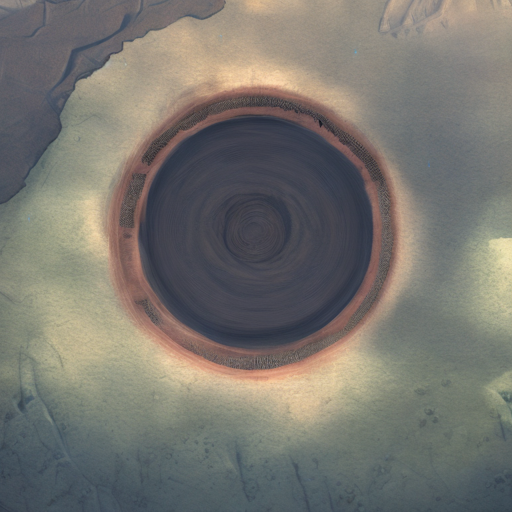

hyper realistic photo of very friendly and dystopian crater





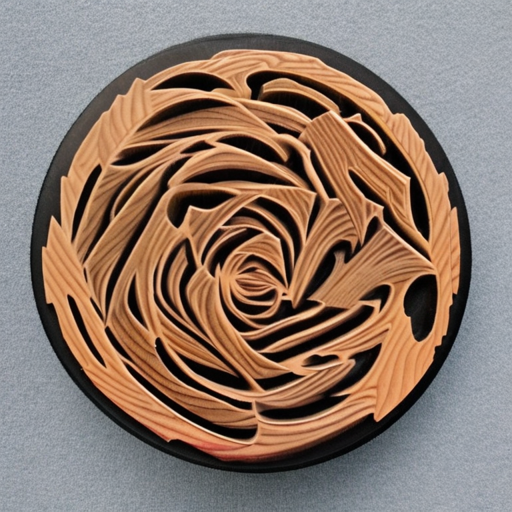

ramen carved out of fractal rose ebony, in the style of hudson river school





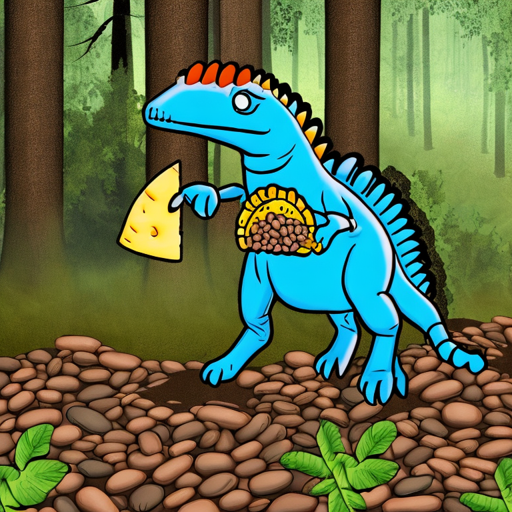

ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus





a thundering retro robot crane inks on parchment with a droopy french bulldog





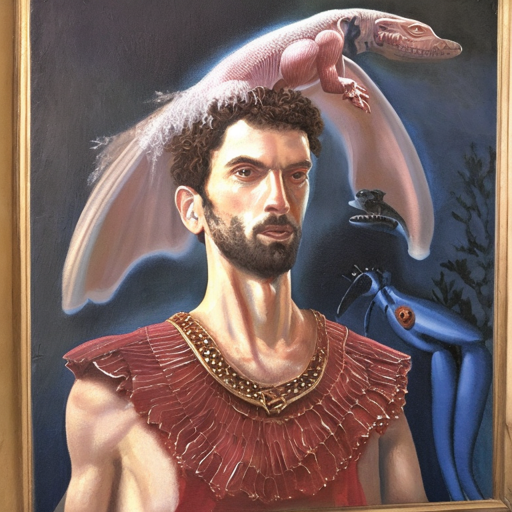

portrait painting of a shimmering greek hero, next to a loud frill-necked lizard





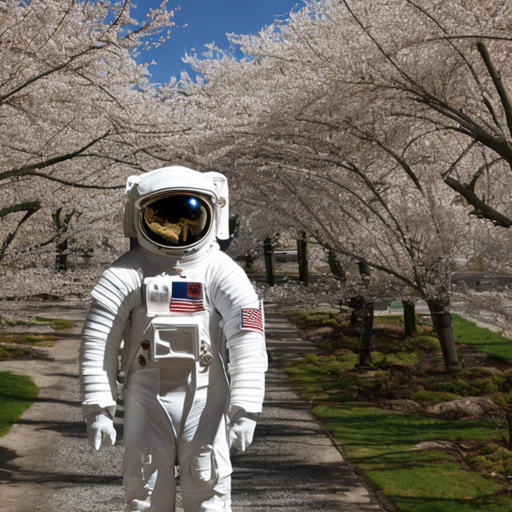

an astronaut standing on a engaging white rose, in the midst of by ivory cherry blossoms





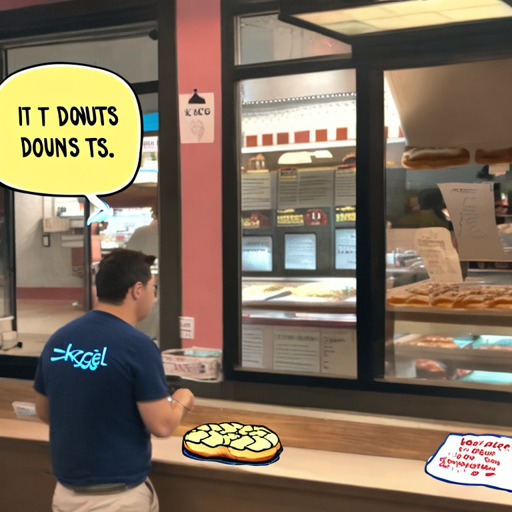

Kaggle employee Phil at a donut shop ordering all the best donuts, with a speech bubble that proclaims "Donuts. It's what's for dinner!"





In [5]:
# LoopING through the prompts and display the corresponding image
path='/kaggle/input/stable-diffusion-image-to-prompts'
for _, row in prompts_df.iterrows():
    image_path = f'{path}/images/{row["imgId"]}.png'
    prompt = row['prompt']
    display(Image.open(image_path))
    print(prompt +'\n\n\n')

In [6]:
# CheckING the shape of the dataframe
print(prompts_df.shape)

(7, 2)


In [7]:
# checking the distribution of prompt length
# Get the length of each prompt
prompt_lengths = prompts_df["prompt"].apply(lambda x: len(x.split()))

# Plot the distribution of prompt lengths
plt.figure(figsize=(10, 6))
sns.histplot(prompt_lengths, kde=True, color="green")
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Prompt Length")
plt.show()

This code calculates the length of each prompt and plots the distribution of prompt lengths using seaborn's histplot() function. This will give us an idea of how long or short the prompts are and their distribution.

We can also check the most common words in the prompts using word clouds. Here's some code to generate a word cloud:

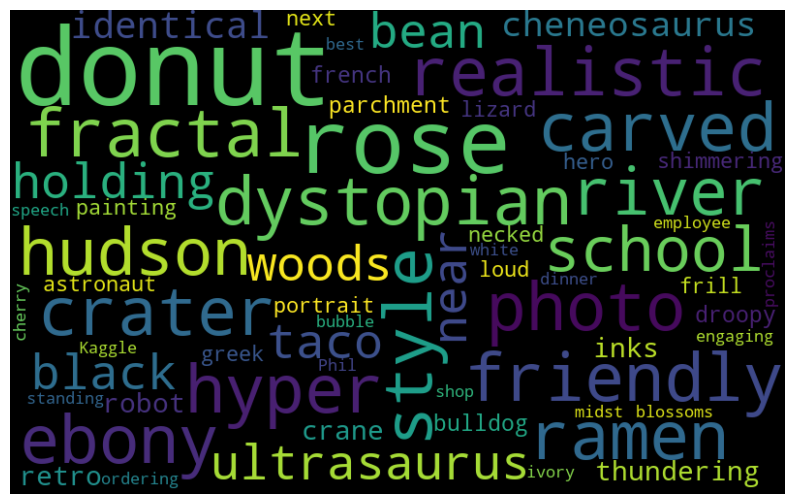

In [8]:
# Join all the prompts together into a single string
text = " ".join(prompt for prompt in prompts_df.prompt)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
# pre processing
# Define the path to the images directory
images_path = '/kaggle/input/stable-diffusion-image-to-prompts/images'

# Define the target size for the images
target_size = (256, 256)

# Define a list to store the preprocessed images
preprocessed_images = []

# Loop through the images in the directory
for image_file in os.listdir(images_path):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(images_path, image_file))
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Convert the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.
    # Add the preprocessed image to the list
    preprocessed_images.append(image)

# Convert the list of preprocessed images to a numpy array
preprocessed_images = np.array(preprocessed_images)

In [10]:
import cv2
import os
import numpy as np

# Define the path to the directory to save the images
new_path = '/kaggle/working/preprocessed-images'

# Create the directory if it doesn't exist
if not os.path.exists(new_path):
    os.makedirs(new_path)

# Loop through the images in the input directory
for image_file in os.listdir(images_path):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(images_path, image_file))
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Convert the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.
    # Get the original filename without the extension
    name, ext = os.path.splitext(image_file)
    # Save the image with the original filename
    image_path = os.path.join(new_path, f"{name}.png")
    cv2.imwrite(image_path, np.clip(image * 255, 0, 255).astype('uint8'))

In [11]:
class CFG:
    device = "cuda"
    seed = 42
    embedding_length = 384
    sentence_model_path = "/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2"
    model_name = "coca_ViT-L-14"
    model_checkpoint_path = "/kaggle/input/open-clip-models/mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k.bin"

We define a configuration class called CFG above. This class contains several class-level variables that are used to configure various aspects of the program.

device : a string that specifies the device (i.e. CPU or GPU) to use for computation. In this case, the value is set to "cuda", which means that the program will use a GPU for computation if one is available.

seed: an integer that is used to seed the random number generator. Setting a seed ensures that the random numbers generated by the program will be the same each time it is run, which can be useful for reproducibility.

embedding_length: an integer that specifies the length of the sentence embeddings that will be generated by the program. Sentence embeddings are dense vector representations of sentences that are used to capture semantic meaning.

sentence_model_path: a string that specifies the path to a pre-trained sentence embedding model. In this case, the path points to a pre-trained model called "all-MiniLM-L6-v2", which is a variant of the MiniLM-L6 transformer model.

model_name: a string that specifies the name of the OpenAI CLIP model that will be used for image-text matching. In this case, the name is set to "coca_ViT-L-14", which refers to a model that has been fine-tuned on the COCA dataset and uses a Vision Transformer (ViT) with 14 layers.

model_checkpoint_path: a string that specifies the path to the checkpoint file for the OpenAI CLIP model. This file contains the trained weights and biases for the model and is used to initialize the model during inference. In this case, the path points to a checkpoint file that has been fine-tuned on the MSCOCO dataset and uses the "coca_ViT-L-14" model architecture.

In [12]:
submission_df = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')
submission_df

val
imgId_eId              
20057f34d_0    0.018848
20057f34d_1    0.030190
20057f34d_2    0.072792
20057f34d_3   -0.000673
20057f34d_4    0.016774
...                 ...
f27825b2c_379  0.012124
f27825b2c_380  0.021575
f27825b2c_381  0.030563
f27825b2c_382  0.014047
f27825b2c_383  0.023764

[2688 rows x 1 columns]

In [13]:
images = os.listdir('/kaggle/working/preprocessed-images')
imgIds = [i.split('.')[0] for i in images]

eIds = list(range(CFG.embedding_length)) # a list containing integers from 0 to (CFG.embedding_length - 1) used later to create a grid of indices that will be used to create unique keys for each image embedding.

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, CFG.embedding_length),
        np.tile(range(CFG.embedding_length), len(imgIds)))] #concatenation of the image ID and an embedding index, separated by an underscore. 

assert sorted(imgId_eId) == sorted(submission_df.index) # checking if ids match.

In [14]:
st_model = SentenceTransformer(CFG.sentence_model_path) # creating a new instance of the SentenceTransformer class from the sentence transformers module.

The SentenceTransformer class is a wrapper for pre-trained sentence embedding models that provides a consistent interface for generating sentence embeddings.

In [15]:
# functions from the open_clip module to create and load a pre-trained OpenCLIP image-text retrieval model.
model = open_clip.create_model(CFG.model_name)
open_clip.load_checkpoint(model, CFG.model_checkpoint_path)

<All keys matched successfully>

In [16]:
# create a PyTorch image transformation pipeline that will be used to preprocess input images before feeding them into the OpenCLIP model.
transform = open_clip.image_transform(
    model.visual.image_size,
    is_train = False,
    mean = getattr(model.visual, 'image_mean', None),
    std = getattr(model.visual, 'image_std', None),
)

In [17]:
# setting the device that will be used to run the OpenCLIP model.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [18]:
prompts = []

images_path = '/kaggle/working/preprocessed-images/'
for image_name in images:
    img = Image.open(images_path + image_name).convert("RGB")
    img = transform(img).unsqueeze(0)

    with torch.no_grad(), torch.cuda.amp.autocast(): # gradients not computed and automatic mixed precision for faster computation
        generated = model.generate(img.to(device))
    
    prompts.append( #generate text prompts
        open_clip.decode( #convert the token IDs to a string
            generated[0]
        ).split("<end_of_text>")[0].replace("<start_of_text>", "").rstrip(" .,")
    )

In [19]:
prompts

['an illustration of a dinosaur eating a piece of cheese',
 'an image of a hole in the ground',
 'an oil painting of a man in a red and gold outfit',
 'a circular wooden carving on a wall',
 'a man standing in front of a counter with a cake',
 'a drawing of a toy robot with scissors on it',
 'a person in a spacesuit walking down a road']

In [20]:
# function to plot image with prompt
def plot_image(image: np.ndarray, title: str) -> None:
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.annotate(
        title, xy=(1.05, 0.5), xycoords='axes fraction',
        ha='left', va='center', fontsize=16, rotation=0, color="#00786b"
    )

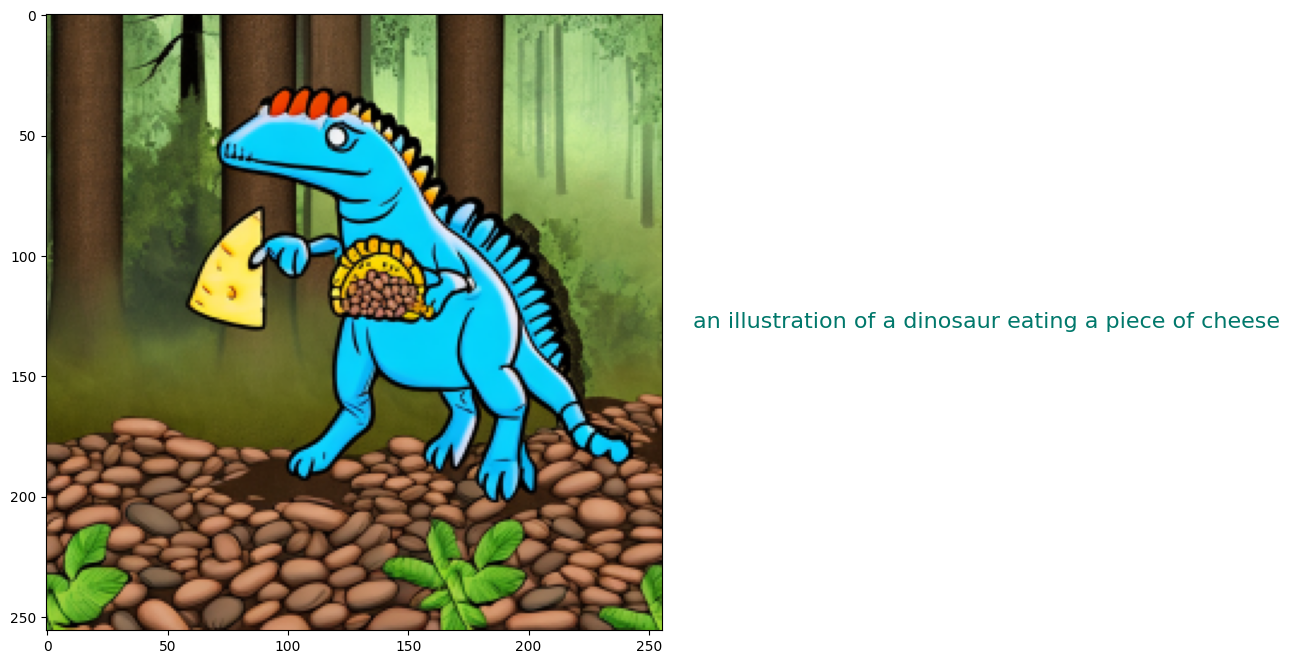

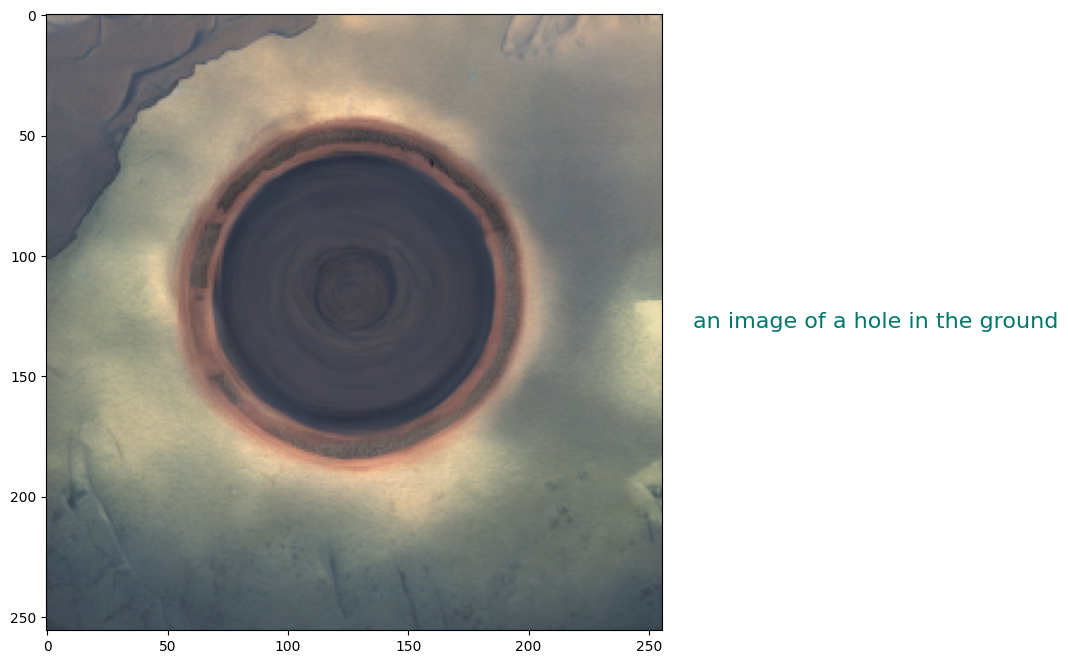

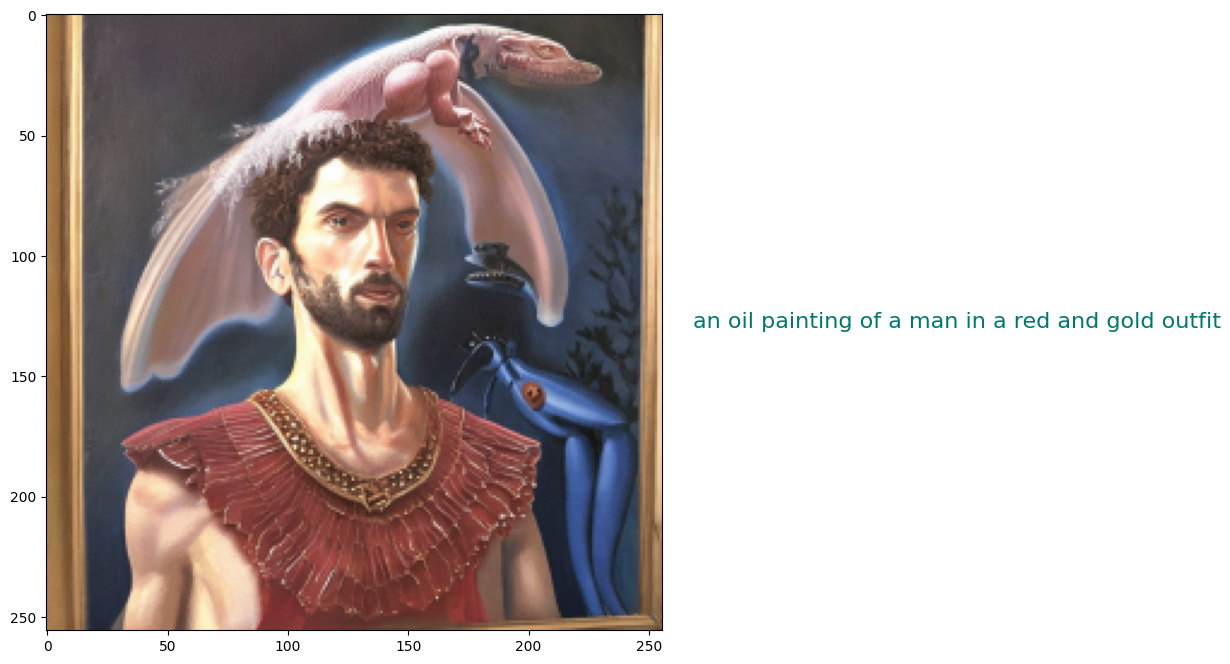

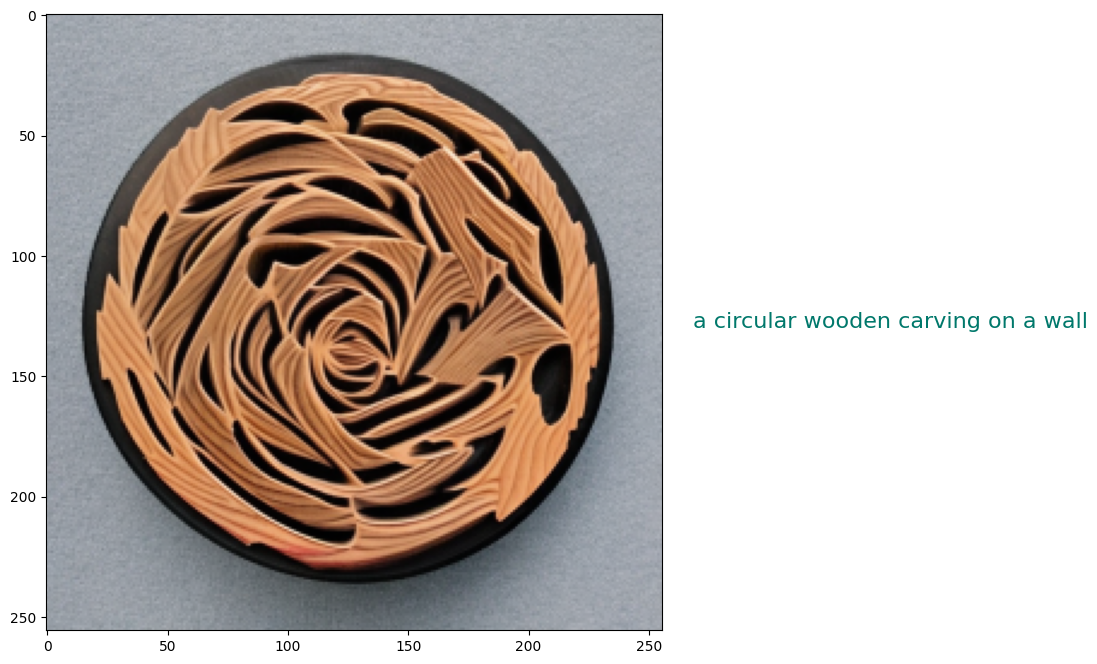

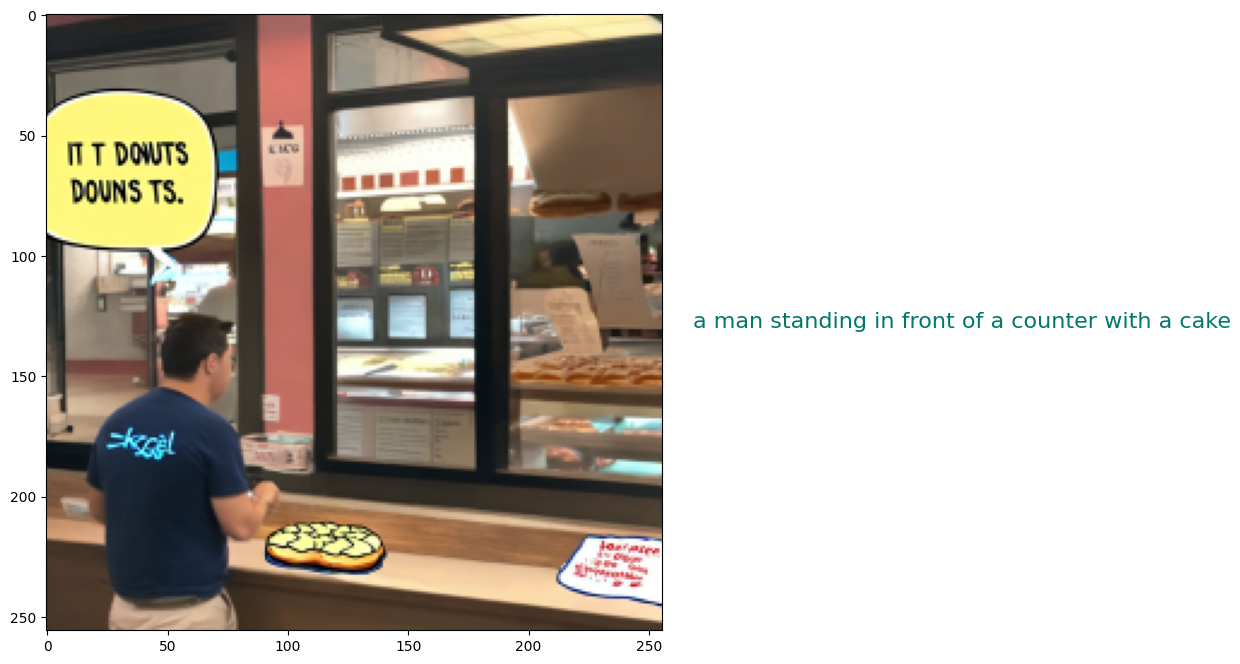

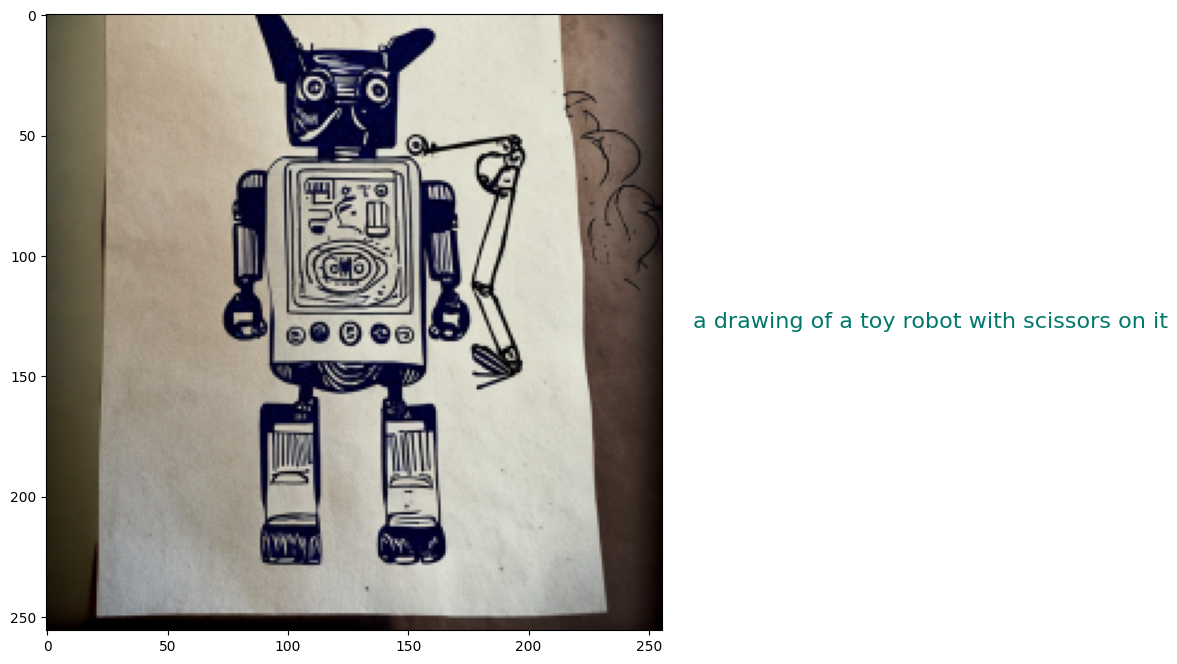

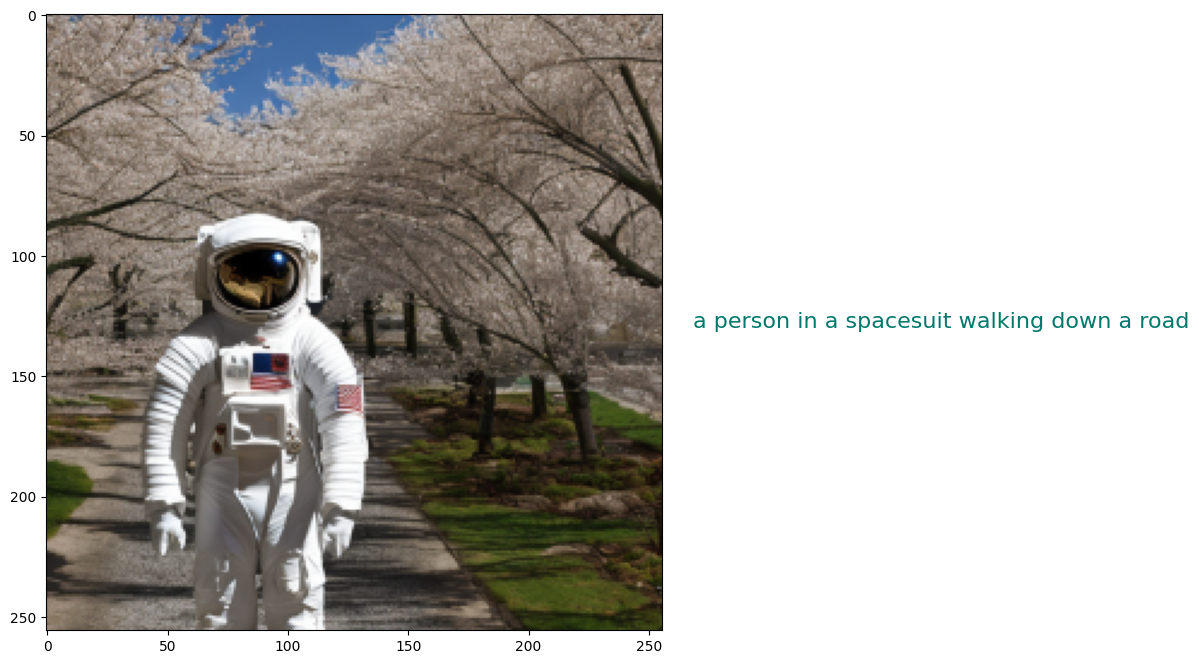

In [21]:
for image_name, prompt in zip(images, prompts):
    img = Image.open(images_path + image_name).convert("RGB")
    plot_image(img, prompt)

In [22]:
prompt_embeddings = st_model.encode(prompts).flatten() #encoding the generated prompts

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# reference_prompts

In [24]:
# prompts

In [25]:
# similarity_scores # each row corresponds to a prompt and each column corresponds to a reference prompt

In [26]:
submission = pd.DataFrame(
    index=imgId_eId,
    data=prompt_embeddings,
    columns=['val']
).rename_axis('imgId_eId')

In [27]:
submission.to_csv('submission.csv')

Reference: https://www.kaggle.com/code/jesherjoshua/coca-clip-and-blip-clip